In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [3]:
def split_xy(data,label):
    x = data.drop(label, axis=1)
    y = data[label]
    return x, y

In [4]:
dataset = pd.read_csv('churn_dataset.csv')
dataset = dataset.set_index('id')

label_encoder = LabelEncoder()
dataset['origin_up'] = label_encoder.fit_transform(dataset['origin_up'])
dataset['channel_sales'] = label_encoder.fit_transform(dataset['channel_sales'])

x, y = dataset.drop('churn', axis=1), dataset['churn']


# Model Building

In [5]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',            
    'max_depth': 8,                  
    'learning_rate': 0.05,
    'n_estimators': 3000,
    'verbosity': 0,
    'scale_pos_weight': 6
}

kfolds = 5
cms = []

kf = KFold(n_splits=kfolds, shuffle=True, random_state=np.random.randint(1,2**32))

for train_index, test_index in kf.split(dataset):
    train = dataset.iloc[train_index]
    test = dataset.iloc[test_index]

    dtrain = xgb.DMatrix(train.drop('churn', axis=1), label=train['churn'])
    dtest = xgb.DMatrix(test.drop('churn', axis=1), label=test['churn'])

    model = xgb.train(params, dtrain, num_boost_round=3000, early_stopping_rounds=30, evals=[(dtest, 'eval')], verbose_eval=0)

    y_prob = model.predict(dtest)
    y_pred = (y_prob >= 0.5).astype(int)

    cm = confusion_matrix(test['churn'], y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f'{cm}\nAccuracy: {accuracy}\n')

    cms.append(cm)

[[2549   55]
 [ 245   55]]
Accuracy: 0.8966942148760331

[[2595   46]
 [ 202   61]]
Accuracy: 0.9146005509641874

[[2556   53]
 [ 230   65]]
Accuracy: 0.9025482093663911

[[2566   59]
 [ 219   59]]
Accuracy: 0.9042369962108164

[[2572   68]
 [ 216   47]]
Accuracy: 0.902170168790906



# Evaluating Results

### Metrics

In [6]:
def cm_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    metrics = {'Accuracy': (tp+tn) / (tp+tn+fp+fn),
     'Sensitivity': tp / (tp+fn),
     'Specificity': tn / (tn+fp),
     'Precision': tp / (tp+fp),
     'Recall': tn / (tn+fn)}
    return metrics

In [7]:
noinforate = (1 - dataset[dataset['churn'] == 1].size / dataset[dataset['churn'] == 0].size)
print(f'\nNo Information Rate: {noinforate}')

cv_accuracy = np.mean([cm_metrics(m)["Accuracy"] for m in cms])
print(f'\nCross-validated Accuracy: {cv_accuracy}')


No Information Rate: 0.8933607744492721

Cross-validated Accuracy: 0.9040500280416668


The no information rate, or just the accuracy from predicting every observation as the majority class, which in this case is customers that didn't churn, is 89.3%. We want our model to be at least better than this in order for the model's predictions to be useful.

Our overall accuracy is 90.4%, showing that our model is capturing some useful trends in the data.

In [8]:
print(f'''
\nSensitivity: {np.mean([cm_metrics(m)['Sensitivity'] for m in cms])}
\nSpecificity: {np.mean([cm_metrics(m)['Specificity'] for m in cms])}
\nPrecision: {np.mean([cm_metrics(m)['Precision'] for m in cms])}
\nRecall: {np.mean([cm_metrics(m)['Recall'] for m in cms])}
''')



Sensitivity: 0.20530978400884373

Specificity: 0.9785825881005656

Precision: 0.5059273135489913

Recall: 0.9202851572185242



Other metrics based off of a 0.5 threshold for classification. These can be adjusted to suit the specific business goals of the company by changing the probability threshold for classification.

### Variable Importances

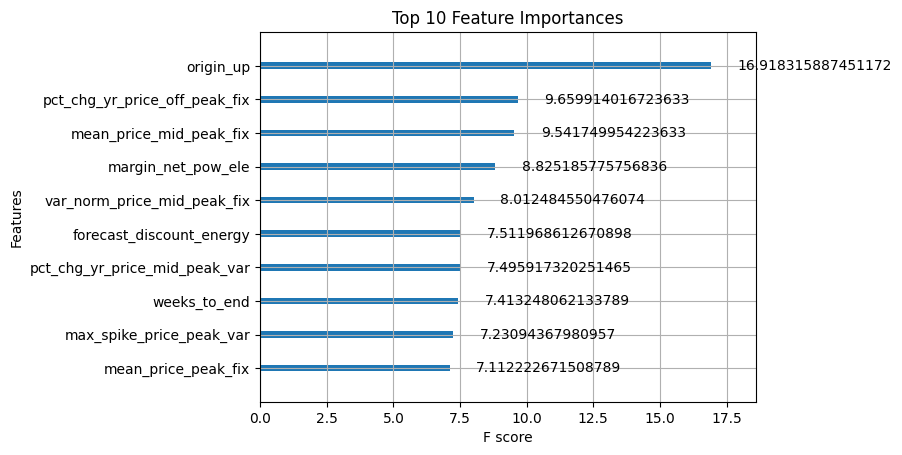

In [11]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

The most significant indicator of churn is the campaign the customer was first subscribed to. This is worth investigating further, to see what specific things these campaigns addressed to influence churn so heavily.

There are many other variables relating to price that can also predict churn quite well. This suggests that price is a pain point that causes customer churn. More specifically, the impact of changes in price over the year as well as sudden changes in price from month to month seems to be very significant. This should influence how we further investigate the root causes of churn, as well as the strategies put into place to prevent it in the future.